In [1]:
pID = 3
pID = 'sub-' + "%03d" % (pID)

In [11]:
import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, KFold

import pickle, json, os
import scipy.io
from bci_funcs import windowed_mean, base_correct, select_mean, slope

path = 'P:\\Lukas_Gehrke\\fastReach\\data\\eeglab2python'
# '/Users/lukasgehrke/Documents/publications/2021-fastReach/' # add path to repository here!!!

# Preconscious Augmentation

This script trains the classifier for a brain-computer interface that controls electrical muscle stimulation in the preconscious augmentation experiment.
The functions used to build the feature vectors are the same that are used for the online application and are found in 'bci_funcs'

A two class linear discriminant model is fitted to idle and pre-movement EEG training data. The model and a channel selection is saved.

In [13]:
from scipy import stats

pre_move = scipy.io.loadmat(path+os.sep+pID+os.sep+'pre_move_Baseline.mat')
idle = scipy.io.loadmat(path+os.sep+pID+os.sep+'idle_Baseline.mat')
chans = np.array(pd.read_csv(path+os.sep+pID+os.sep+'sel_chans.csv', header=None)).flatten()
chans = chans - 1 # Matlab to python indexing

chans = chans[0:15]
chans = chans.tolist() # first three channels are C3, C4, Cz, in that order. Might ignore, then start index at 3

data_srate = 250
windows = 10
sel_window = 10
baseline = data_srate/windows

idle = idle['idle'][chans,:,:]
pre_move = pre_move['pre_move'][chans,:,:]

idle_means = np.zeros((idle.shape[2], idle.shape[0] * (windows)))
pre_move_means = np.zeros((pre_move.shape[2], pre_move.shape[0] * (windows)))

idle_mean = np.zeros((idle.shape[2], idle.shape[0]))
pre_move_mean = np.zeros((pre_move.shape[2], pre_move.shape[0]))

slope_idle = np.zeros((idle.shape[2], idle.shape[0]))
slope_pre_move = np.zeros((pre_move.shape[2], pre_move.shape[0]))

target_class = 1
threshold = 1
classifier_update_rate = 10 # samples

bci_params = dict(((k, eval(k)) for k in ('chans', 'windows', 'baseline', 'target_class', 'threshold', 'data_srate', 'classifier_update_rate')))
with open(path+os.sep+pID+os.sep+'/bci_params.json', 'w') as f:
    json.dump(bci_params, f)

for trial_ix in range(0, pre_move.shape[2]):
    tmp = base_correct(pre_move[:,:,trial_ix], baseline-1)
    pre_move_means[trial_ix, :] = windowed_mean(tmp, windows).flatten()
    pre_move_mean[trial_ix, :] = select_mean(tmp, windows, sel_window).flatten()
    slope_pre_move[trial_ix, :] = slope(tmp, 'linear').flatten()

for trial_ix in range(0, idle.shape[2]):
    tmp = base_correct(idle[:,:,trial_ix], baseline-1)
    idle_means[trial_ix, :] = windowed_mean(tmp, windows).flatten()
    idle_mean[trial_ix, :] = select_mean(tmp, windows, sel_window).flatten()
    slope_idle[trial_ix, :] = slope(tmp, 'linear').flatten()

win_means = np.concatenate((pre_move_means, idle_means), axis = 0)
win_mean = np.concatenate((pre_move_mean, idle_mean), axis = 0)
slope = np.concatenate((slope_pre_move, slope_idle), axis = 0)

In [14]:
pre_move_class = np.ones((pre_move_means.shape[0], 1))
idle_class = np.zeros((idle_means.shape[0], 1))
classes = np.concatenate((pre_move_class, idle_class)).ravel()

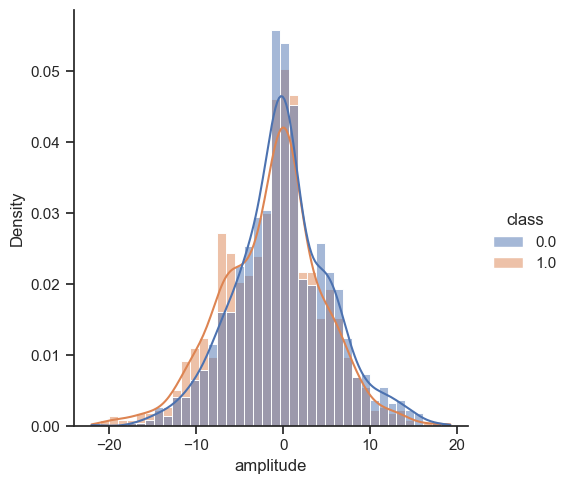

In [15]:
data = slope

data_to_plot = pd.DataFrame(data)
data_to_plot['class'] = classes
data_to_plot = data_to_plot.melt(id_vars = 'class', value_name = 'amplitude')

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")
sns.displot(x="amplitude", hue="class", data=data_to_plot, kde=True, fill=True, stat="density")


In [17]:
clf = LDA(solver='eigen', shrinkage='auto')
clf.fit(data, classes)

kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
cv_results = cross_val_score(clf, data, classes, cv=kfolds)
print(cv_results.mean())
print(cv_results.std())

filename = path+os.sep+pID+os.sep+'model_'+pID+'_eeg.sav'
pickle.dump(clf, open(filename, 'wb'))

0.75
0.05050762722761051
